## Importing Dependencies


In [ ]:
## Checking for GPU Access
!nvidia-smi

Tue Oct 24 02:14:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:

# download data
import gdown
PATH = 'images/'
url = 'https://drive.google.com/uc?id=1-YzEPLzgX9g4e064ptD2E_AKudMttbzd'
output = 'images.zip'  # Replace with your desired filename and its extension.
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1NUQ53axEWZwez5wvcahTf4_sDylRM4Kz'
output = 'descriptions.csv'  # Replace with your desired filename and its extension.
gdown.download(url, output, quiet=False)




Downloading...
From: https://drive.google.com/uc?id=1-YzEPLzgX9g4e064ptD2E_AKudMttbzd
To: /content/images.zip
100%|██████████| 27.5M/27.5M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NUQ53axEWZwez5wvcahTf4_sDylRM4Kz
To: /content/descriptions.csv
100%|██████████| 841k/841k [00:00<00:00, 166MB/s]


'descriptions.csv'

In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/28e3ea93-978e-4e79-ad29-7ade158ff608.jpg  
  inflating: images/4b4a5ad8-2ecf-4d0a-81c3-5b4594d61ac6.jpg  
  inflating: images/6bdce679-989b-4b34-baae-78272ec0a354.jpg  
  inflating: images/93a69e30-6234-4556-8cfd-1ea167d9f009.jpg  
  inflating: images/2e77f2c3-718c-4607-b05c-1add8501daa9.jpg  
  inflating: images/9428c3e1-8450-4300-96d9-a6496745b55b.jpg  
  inflating: images/94268d86-4c82-4c52-be21-dfbb9038bc37.jpg  
  inflating: images/fd029acb-2964-4ce5-b2e0-8273793a6324.jpg  
  inflating: images/fa4f5ee7-4ba7-4377-b966-b6116b383994.jpg  
  inflating: images/309cf33f-5276-4e38-908d-44b1154d9d30.jpg  
  inflating: images/9916ded4-ff2e-4ec1-8133-687078468d8c.jpg  
  inflating: images/1ab9e9a0-f639-428b-93ff-60ca9c2202c2.jpg  
  inflating: images/eff477d8-17a4-478a-bb14-2f7c0cd05732.jpg  
  inflating: images/e3f71c5f-881c-4df9-af1d-399f54a2f271.jpg  
  inflating: images/42f7a70e-faaf-4edf-abec-53f6dd3e8cb7.jpg  
  inflating: 

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("descriptions.csv")

# Convert the DataFrame to a dictionary
annotations  = df.to_dict(orient='records')


In [ ]:
# Group all captions together having the same image ID.
import collections
image_path_to_caption = collections.defaultdict(list)
for val in annotations:
  de = val['description'].replace('\n', '')
  de= de.replace('\xa0', '')
  caption = f"<start> {de} <end>"
  image_path = PATH + val['file']
  image_path_to_caption[image_path].append(caption)

In [ ]:

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

4516


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
train_captions

['<start> There is one large tape diagram consisting of two lines. The first, labelled with an S to the left, has 3 equal sized boxes containing the number 12 inside each.The second is placed directly below, lining up each of the 4 equivalent boxes containing the number 12 inside each as well, with the boxes above it, so the last section of 12 extends beyond.  It is labelled with an L to the left. <end>',
 '<start> For the equation ( 5+y=15) there is a tape diagram using a rectangle that is divided it into 2 sections, one is labeled 5 the other is labeled 10 <end>',
 '<start> Wrote divided by 2 on both sides and 6:2.5 <end>',
 '<start> There is a dashed line drawn to complete the diameter. The number 4 is written above the diameter. The number 2 is written below the radius. <end>',
 '<start> rectangle composed of two small right triangles with one-half written inside of each, two medium right triangles with one-half written inside of each, and a middle square divided into two small tri

<start> Extended the sides of the polygon to make it a rectangle. Write "h" and "10" on the side and "b" on the bottom. <end>


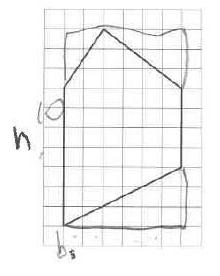

In [ ]:
## Sanity check
print(train_captions[25])
Image.open(img_name_vector[25])

Currently, `train_captions` is an array of captions corresponding with each image in `image_name_vector` which is an array o fimage paths

The captions in the `train_captions` array are tokenized using the TensorFLow TextVectorizer with tunable hyperparameters.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\.,/:;?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
cap_vector

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

At the End, while making the predictions, I also have to detokenize the tokens into word sequences for which two layers below are initialized to create mappings for words to indices and indices to words

`index_to_word` is used to detokenize the tokens while making predictions

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

As of now, the images are in the `image_name_vector` array as image paths. The model requires imagees to be fed as matrices

For this implementation, as the pretrained vision transformer model is used, the vision transformer requires images to be in the dimensions `(batch_size, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)`

For the Vision transformer used:

`IMAGE_SIZE` is 224

In [ ]:
## FUnction to load the images into the required format
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    return img

In [ ]:
image_ds = tf.data.Dataset.from_tensor_slices(img_name_vector)
image_ds = image_ds.map(
  load_image)

In [ ]:
## Sanity. check on the dataset

In [ ]:
## Normalizing the images in the dataset to be suitable for the neural network
def rescale(img):
  return img/255.

image_ds = image_ds.map(rescale)

## Initializing the pretrained Vision Transformer

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.5 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


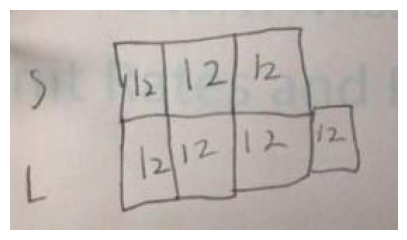

In [ ]:
## Image size for the Vision Transformer
IMAGE_SIZE = 224


import matplotlib.pyplot as plt
try_img = plt.imread(img_name_vector[0])
try_img = try_img/255.
plt.figure(figsize = (5, 5))
plt.imshow(try_img)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([try_img]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Instead of classification I need the vision transformer to output a tensor of shape `(batch_size, seq_len, d_model)`

So we use the second to last layer on the vision transformer as the final layer giving the output shape: `shape=(None, 50, 768)`

In [ ]:
new_input = vit_model.input
hidden_layer = vit_model.layers[-2].output
## The New Vision Transformer Model with the required output shapes
vision_transformer_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
## For experimentation, freeze the layers of the pretrained Vision transformer
for layer in vision_transformer_model.layers:
  layer.trainable = False

In [ ]:
## Checking the model summary
vision_transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)         

### Positional Encodings for the captions

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

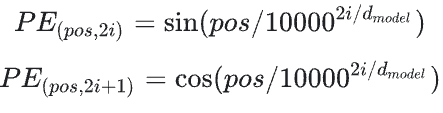

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking the sequences

The sequences are masked to seperate real tokens from paddings, the following create the masks for the tokens

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled Dot Product Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

## Multi-Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    #print(f"Query shape: {q.shape}")
    #print(f"Key shape: {k.shape}")
    #print(f"value shape: {v.shape}")

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## The Encoder Layer

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, d_model, vision_transformer):
    super(Encoder, self).__init__()
    self.vit = vision_transformer
    self.units = d_model
    self.dense = tf.keras.layers.Dense(self.units, activation=tf.nn.gelu)

  def call(self, x, training, mask):
    ## x: (batch, image_size, image_size, 3)
    x = self.vit(x)
    x = self.dense(x)
    return x

In [ ]:
### Testing the Encoder
sample_encoder = Encoder(1024, vision_transformer_model)
sample_encoder_output = sample_encoder(resized_image, training=False, mask=None)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(1, 50, 1024)


## The Decoder

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
### Decoder Layer:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    #print(f"Decoder Layer input x shape: {x.shape}")

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    #print("attn2 shape: ", attn1.shape)
    #print(f"x shape: {x.shape}")
    out1 = self.layernorm1(attn1 + x)

    #print(f"Encoder outpur (Value and key) shape: {enc_output.shape}")
    #print(f"out1 (Query) shape: {out1.shape}")

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, None)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size, max_tokens,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.max_tokens =  max_tokens

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(max_tokens, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=1024, num_heads=8,
                         dff=2048, target_vocab_size=8000, max_tokens = 128)
temp_input = tf.random.uniform((1, 50), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([1, 50, 1024]), TensorShape([1, 8, 50, 50]))

## The Transformer

![image.png](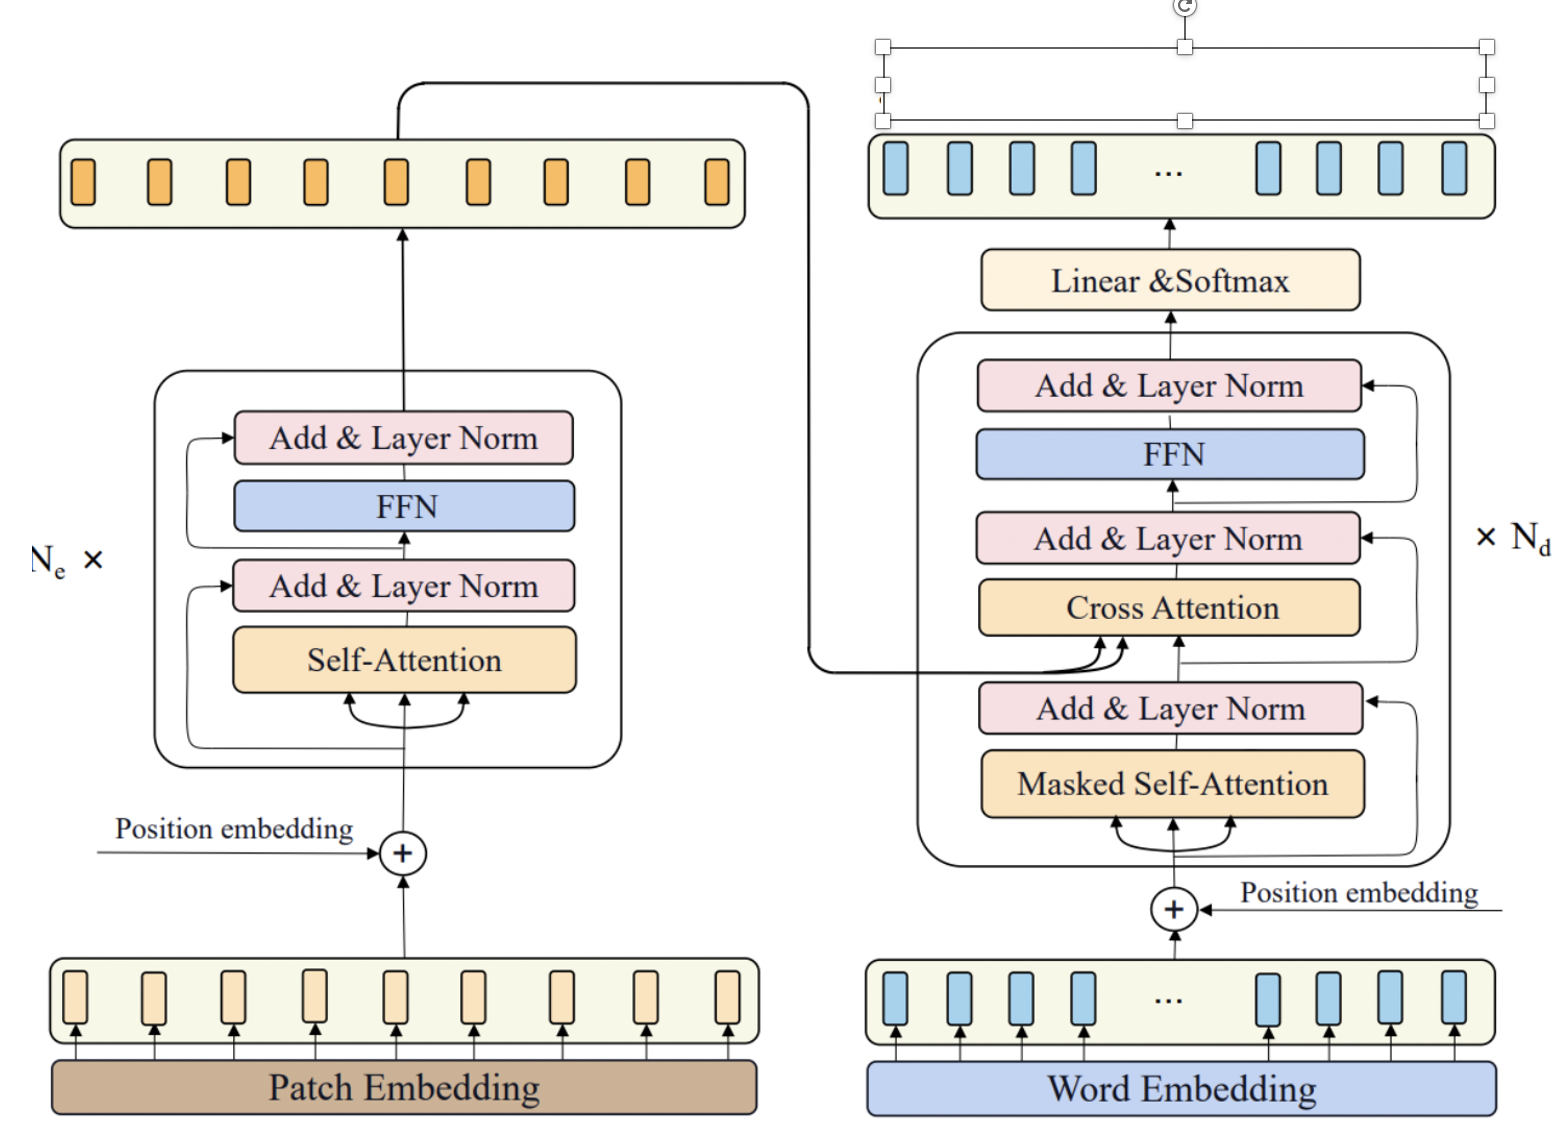FZM5DRrsyDapGxgGqot/VpXU+eTWlHFy2HHoFLVcval7zHeIC5OZt2Dog/aaEHb3rFIxmid5WrBUtzQI9RuJc9iRbVI3MAxUdfMFMs26umXkb8aRbVIXDf9/c2e4HDcMAuH3f+sYn8Agdi0ky5frTCsEH+xKmmuaP2mLfep25gHu+LqqGn5NHlLiuq5c+u3Pqj/nESP7HfLZlkHBFdb1SrnMZ+7Nn2UWgTQHCiBlR7jxZyXUr0VUozlQACnobeWzqh79WtJrUIk9hu/y5n1qnDykxHVduZS8GWKBCu1Y89Cc4TplFoEod0ppQdcj2UKX4aZapcwikOZAAaTU79CkAKhfG1GN5kABpKDers9DSa9BJVbu5wDd11Vrs0Ava2FNM1ICXpcpMW8G7AwmvXXSubsDdItAlDt5UGgpUFGFtJZZBNIcKIAUfODuXc0w6tciqtEcKIDUNm/q0a8lvQY51kIL3NDu3gyxwLGPwzw0Z5zI4Q3+J5gX0n3DdBWmIjEhv5d+MQtooGNduCT7qAl5QwMR5/5iRy00Vz3wqVmAkTcqvlBAFphmY62FccyGNTJgY555c+8qCMOCkynfU3CQ8ZuyN9+kMbMwOCxr07FwXWoCkwberANx7k2NqwRV76emwroCAeQNYN9MmVvxZpuCgxm2MO4WYffm3lUQhoXZU7497OMwcbgpextOaoBYGRx2ye1SEzA98GYdiHNvalwlqHo/NRXWFQggbwD7ZsrcijfbYAfB/oDFExazQRjPEKSADc8YpoefH//swCVvQfxmI1a2Dmxaz454Ga56q3LXZB5VvQdN1+TCUyRwXPZfKuKt99sZCfYHbNf6+la8BX8ziuwsYWCDGDvQC6MG7LAsHrYObIqLZ0t+q96qXBIoJtB5gqYDXHhOD1xR71uYeOv9dtqC/OoRHnlj5w6HbRBju7t6dSsegrcbNcSt/jvzRiaUkGYA2qbKod5KDr0V0+yfl3EV3bcZ5s29qyAMW7eHLnR+2iNvzAI6rGNdOG/4aQfyhmYi7njTP3E2MrNa+MC2AAAAAElFTkSuQmCC)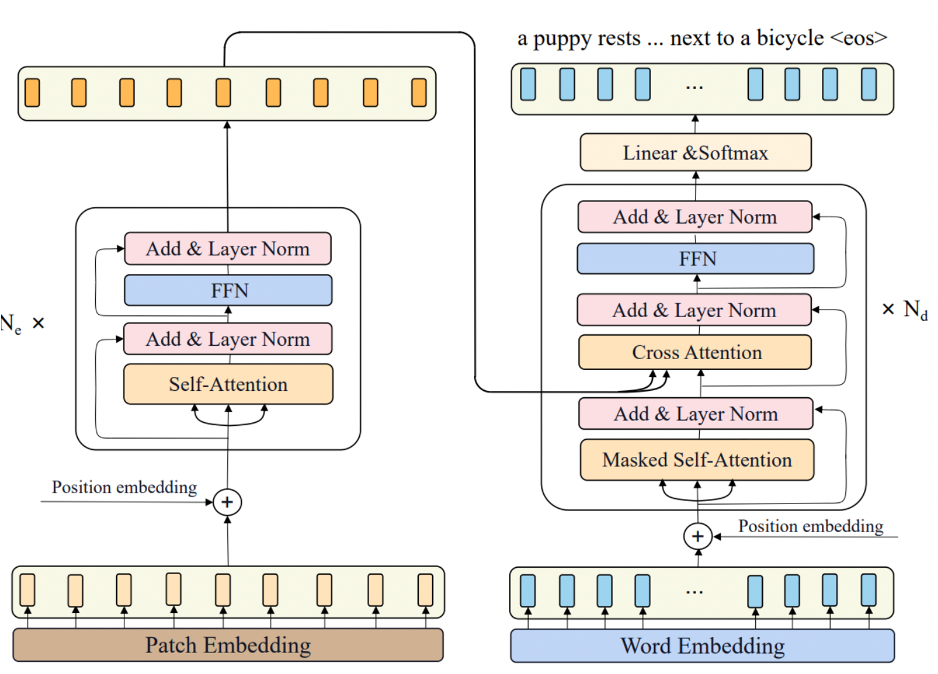

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff,
               target_vocab_size, vision_transformer, max_tokens, rate=0.1):
    super().__init__()
    self.vision_transformer = vision_transformer
    self.encoder = Encoder(d_model,
                           self.vision_transformer)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, max_tokens=max_tokens, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    #print("Transformer call function called")
    inp, tar = inputs
    #print(f"inp: {inp.shape}.     tar: {tar.shape}")
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    #print(f"Mask shapes: {padding_mask.shape}.    {look_ahead_mask.shape}")

    enc_output = self.encoder(inp, training, None)  # (batch_size, inp_seq_len, d_model)
    #print("Encoder Works")
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, vision_transformer = vision_transformer_model, max_tokens=128)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((1, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([resized_image, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([1, 36, 8000])

## Hyperparameters:

In [ ]:
## Hyperparameters for transformers
num_layers = 8
d_model = 256
dff = 512
num_heads = 4
dropout_rate = 0.1

## The Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate , beta_1=0.9, beta_2=0.98, epsilon=1e-9)


Text(0.5, 0, 'Train Step')

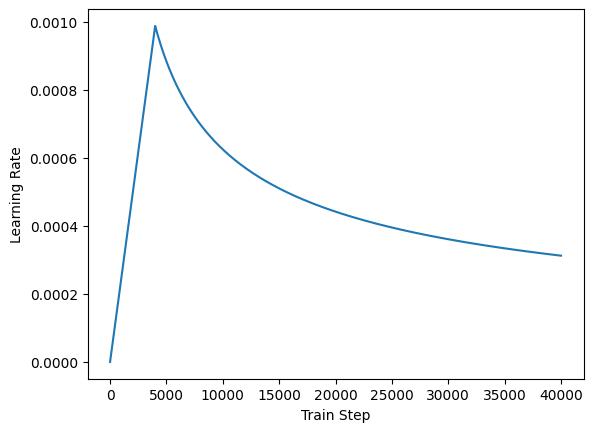

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training the Transformer





In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=vocabulary_size,
    vision_transformer = vision_transformer_model,
    max_tokens = 128,
    rate=dropout_rate)

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 50

The `@tf.function` is added as a decorator to speed up the training process by converting it to a graph executable:

More information on the official Tensorflow Documantation:

https://www.tensorflow.org/api_docs/python/tf/function

In [ ]:
@tf.function
def train_step(inp, tar):
  #print(inp.shape)
  #print(tar.shape)
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  #print(tar_inp)
  #print(tar_real)

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

## Preparing Data for training

In [ ]:
image_ds, cap_vector

(<_MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>,
 <_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>)

In [ ]:
# Step 1: Calculate the size of the datasets.
num_elements = tf.data.experimental.cardinality(image_ds).numpy()

# Step 2: Decide on the split ratio.
train_size = int(0.8 * num_elements)
val_size = num_elements - train_size

# Step 3: Use the take and skip methods to split datasets.
train_image_ds = image_ds.take(train_size)
val_image_ds = image_ds.skip(train_size)

train_cap_vector = cap_vector.take(train_size)
val_cap_vector = cap_vector.skip(train_size)

# Finally, create the train and validation batches
train_batches = tf.data.Dataset.zip((train_image_ds, train_cap_vector))
val_batches = tf.data.Dataset.zip((val_image_ds, val_cap_vector))


In [ ]:
train_batches

<_ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_batches = train_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_batches = val_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for (batch, (inp, tar)) in enumerate(train_batches):
  print(batch)
  print(inp.shape)
  print(tar[:, :-1].shape)
  break

0
(64, 224, 224, 3)
(64, 49)


In [ ]:
def model_evaluation(val_batches):
# Initialize a variable to keep track of the running sum of accuracies
  total_accuracy = 0

  # Keep track of the number of batches
  num_batches = 0

  for (batch, (inp, tar)) in enumerate(val_batches):
      # ... (the rest of your code)
      tar_inp = tar[:, :-1]
      tar_real = tar[:, 1:]
      # Calculate accuracy for the current batch
      predictions, _ = transformer([inp, tar_inp],
                                 training = )
      batch_accuracy = accuracy_function(tar_real, predictions)

      # Update the total accuracy and number of batches
      total_accuracy += batch_accuracy
      num_batches += 1

  # Calculate the average accuracy
  average_accuracy = total_accuracy / num_batches
  return average_accuracy



### Training the Transformer

In [ ]:
Train = []
Val = []

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    #print(inp, tar)
    train_step(inp, tar)

    if batch % 10 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
  val_accuracy = model_evaluation(val_batches)
  Train.append(train_accuracy.result())
  Val.append(val_accuracy)
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Train_Accuracy {train_accuracy.result():.4f} Val_Accuracy {val_accuracy:.4f}')
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.5720 Accuracy 0.0000
Epoch 1 Batch 10 Loss 8.5629 Accuracy 0.0004
Epoch 1 Batch 20 Loss 8.5487 Accuracy 0.0003
Epoch 1 Batch 30 Loss 8.5250 Accuracy 0.0004
Epoch 1 Batch 40 Loss 8.4958 Accuracy 0.0014
Epoch 1 Batch 50 Loss 8.4617 Accuracy 0.0076
Epoch 1 Loss 8.4392 Train_Accuracy 0.0131 Val_Accuracy 0.0675
Time taken for 1 epoch: 53.36 secs

Epoch 2 Batch 0 Loss 8.2256 Accuracy 0.0665
Epoch 2 Batch 10 Loss 8.1882 Accuracy 0.0624
Epoch 2 Batch 20 Loss 8.1495 Accuracy 0.0627
Epoch 2 Batch 30 Loss 8.1040 Accuracy 0.0641
Epoch 2 Batch 40 Loss 8.0634 Accuracy 0.0636
Epoch 2 Batch 50 Loss 8.0202 Accuracy 0.0640
Epoch 2 Loss 7.9943 Train_Accuracy 0.0641 Val_Accuracy 0.0681
Time taken for 1 epoch: 25.49 secs

Epoch 3 Batch 0 Loss 7.7193 Accuracy 0.0690
Epoch 3 Batch 10 Loss 7.6957 Accuracy 0.0629
Epoch 3 Batch 20 Loss 7.6560 Accuracy 0.0630
Epoch 3 Batch 30 Loss 7.6008 Accuracy 0.0643
Epoch 3 Batch 40 Loss 7.5516 Accuracy 0.0637
Epoch 3 Batch 50 Loss 7.4989 Accuracy 0.06

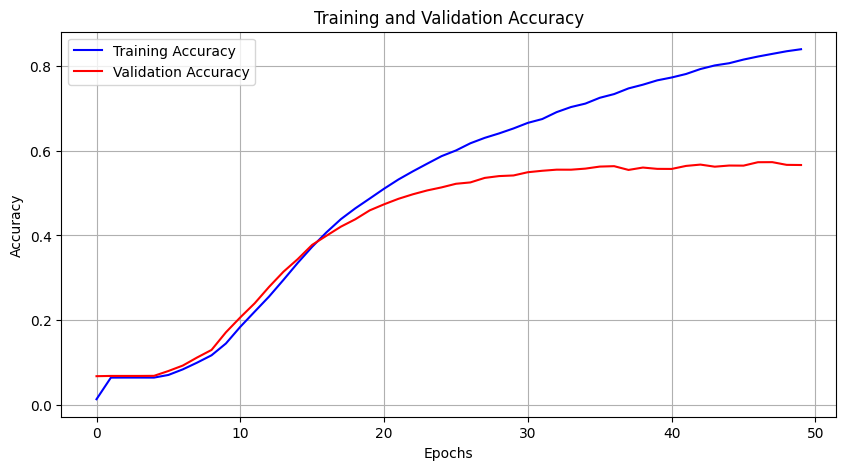

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Train, label='Training Accuracy', color='blue')
plt.plot(Val, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Function to caption the images

In [ ]:
def caption_image(image_path, transformer):
  """
  Uses the Transformer passed in the argument to caption the image
  """
  img = plt.imread(image_path)
  resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  ## Scaling the images
  resized_image = resized_image/255.
  ## Initializing the output arrays
  output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_array = output_array.write(0, [3])
  output = tf.transpose(output_array.stack())


  for i in tf.range(50):
    output = tf.transpose(output_array.stack())
    predictions, _ = transformer([resized_image, output], training=False)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output_array = output_array.write(i+1, predicted_id[0])
    if predicted_id == [4]:
      break

  output = tf.transpose(output_array.stack())
  output_tensor = index_to_word(output)
  output_tensor= " ".join([word.decode('utf-8') for word in output_tensor.numpy()[0]])
  print(output_tensor)
  plt.figure(figsize =  (5,  5))
  plt.imshow(resized_image[0])
  plt.axis("off")

<start> "two figures", [UNK] area", [UNK] [UNK] are underlined in the question.labels for d and e are circled in the question.labels for 2 and e are circled <end>
<start> shape e is circled. <end>
<start> the student draws a diagram with five parts and two parts shaded. <end>
<start> drew a tape diagram. divided it into five sections. labeled each section[not readable quality] <end>
<start> student plots a point at about \left(3.1,-5.5\right) <end>


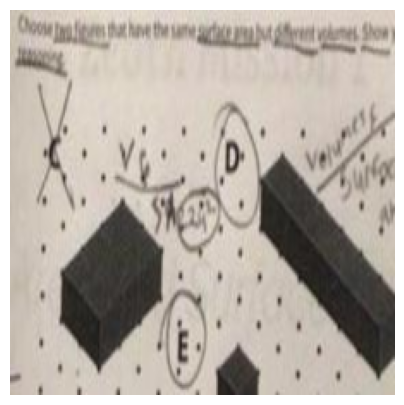

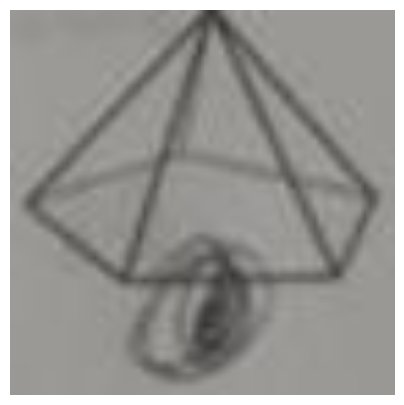

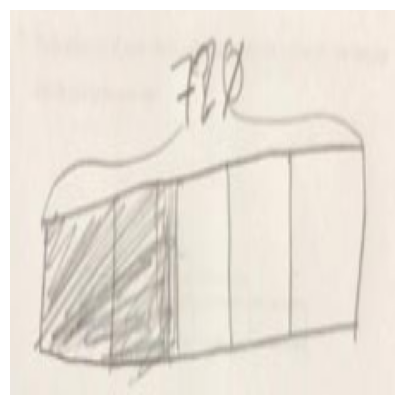

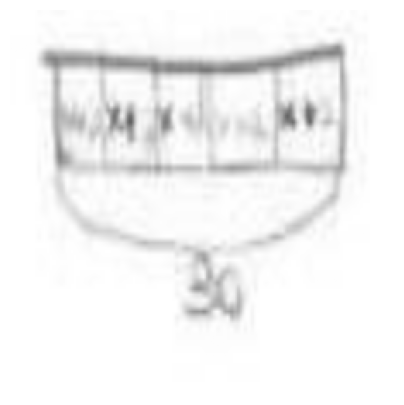

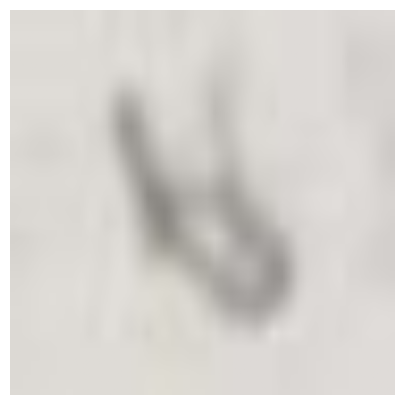

In [ ]:
import random
for i in range(5):
  a = random.randint(0, 4000)
  caption_image(img_name_vector[a], transformer)